# Que nous dit le nombre de cas sur la dangerosité du COVID-19?

> Comparaison du nombre de cas aux nombre de personne dans les autres états de la maladie au cours du temps.


- toc: true
- branch: master
- hide: false
- search_exclude: false
- badges: true
- comments: true
- author: Alexandre Payot
- categories: [Visualisation, Data, Covid]

Ce blog post est mon deuxième sur l’évolution du COVID-19 en France, où le premier cherchait à extraire des métriques qui indiquerait de manière robuste la trajectoire du coronavirus, dans ce deuxième nous cherchons à comprendre ce que l’on peut apprendre du nombre de « cas confirmés ». Connaitre le nombre de cas à un moment donné et son évolution dans le temps permet de comprendre la dangerosité du SARS-CoV-2 et de calculer les taux de reproduction de la maladie (R).

Malheureusement comparé aux nombres d’hospitalisations, de réanimations et de décès ; le nombre de personne ayant le COVID-19 à un moment donné est très incertain. En effet le nombre de cas confirmés ne capture pas tous les cas :

* Lorsque le nombre de tests est limité, seul les cas critiques sont testés ;
* Il est maintenant documenté que le test PCR peut apparaitre négatif pour une personne infectée ;
* Les asymptomatiques ne sont testés que dans le contexte de dépistage massif et de l’établissement de chaînes de contacts.

De plus, ces facteurs ont changé au cours de la pandémie. Nous allons tenter de comprendre comment ces facteurs ont évolué pendant la durée de la pandémie.


In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
#collapse-hide
import pandas as pd
from matplotlib import pyplot as plt
import requests
import datetime
from IPython.display import display, Markdown
import viz

In [3]:
#collapse-hide
display(Markdown("Article publié le 18/10/2020"))
display(Markdown("Article mis à jour le {}".format(datetime.date.today().strftime("%d/%m/%Y"))))

Article publié le 18/10/2020

Article mis à jour le 13/01/2021

In [4]:
#collapse-hide

from viz import *
import viz

In [5]:
#collapse-hide
file_name = 'opencovid19-fr-chiffres-cles.csv'
url = 'https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv'
myfile = requests.get(url)
open(file_name, 'wb').write(myfile.content)
data = pd.read_csv('opencovid19-fr-chiffres-cles.csv')
data = enable_time_series_plot(data, timein_field="date", timeseries_field_out="t")

In [6]:
#collapse-hide

maille_active = 'FRA'
fra, name = oc19_data_preparation(data, maille_active)

# Personne tombant malade le 5 Main:
fra["test"] = 0
fra.loc["2020-05-01","test"] = 1

In [7]:
# hide
# define some axis formatting tricks
import matplotlib.ticker as mtick


def format_tick(x, pos):
    if x >= 0.9:
        out = f"{int(x)}"
    else:
        out = f"{x}"
    return out

def format_tick_multi(x, pos):
    if x >= 0.9:
        out = f"{int(x)}x"
    else:
        out = format_tick_percent(x, pos)
    return out
    

def format_tick_percent(x, pos):
    x=x*100
    if x >= 0.9:
        out = f"{int(x)}"
    else:
        out = f"{x}"
    return f'{out}%'

## Mise à jour des observations

### Mise à jour du 14/11/2020

Les estimations de mortalité en réanimation pour le mois d'Octobre, Novembre on atteint le même pic que ceux du mois d'Avril. L'augmentation rapide de la mortalité rapide en réanimation n'a pas etait suivi d'une augmentation de la mortalité à l'hôpital aussi rapide. Cela semble du à une réduction de la proportion de transfert en réanimation des personnes hospitalisées pour limiter l'utilisation des services aux cas les plus extrèmes.

## Approximation du nombre de malades à un moment donnée

La première étape est d'établir une estimation du nombre de personne ayant le COVID-19 à un moment donné à partir du nombre de cas confirmés. Pour se faire nous avons besoin d’estimer la durée de la maladie. Les [études de l’institut pasteur]() donnent une maladie qui en moyenne dure 21 jours, 5 avant l’apparition des symptômes, et 16 après. Nous allons partir du principe que la maladie est confirmée officiellement 2 jours après l’apparition des symptômes.
Une personne est donc considérée malade 7 jours avant son test et jusqu’à 14 jours après.


In [8]:
#collapse-hide
jour_de_contamination_avant_le_résultat = 7
durée_totale_de_la_maladie = 21

state_start = - jour_de_contamination_avant_le_résultat
state_end = durée_totale_de_la_maladie + state_start

malades = viz.state_tracking(fra, state_start, state_end)

disease_states = pd.DataFrame()
disease_states["malades"] = malades["cas_confirmes_jour"]

Prennons l'exemple d'une personne dont le cas est confirmé le 1er Mai:

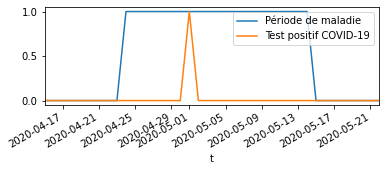

In [9]:
#collapse-hide
ax = malades["test"].plot(label="Période de maladie")
fra["test"].plot(ax=ax, label="Test positif COVID-19")
ax.legend()
ax.figure.set_size_inches(6, 2)
axis_date_limits(ax,'2020-04-15', '2020-05-22')

Notre estimation la considère malade du 24/04 au 14/05.

Maintenant comparons notre estimation du nombre de malades au nombre de cas confirmé par jour: les deux se suivent mais le pic du nombre de malades intervient quelques jours après le pic du nombre de nouveaux cas.

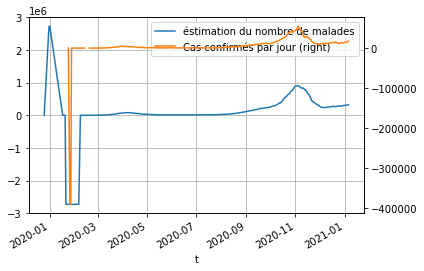

In [10]:
#collapse-hide
cas = pd.DataFrame()
cas["éstimation du nombre de malades"] = disease_states["malades"]
cas["Cas confirmés par jour"] = fra["cas_confirmes_jour"].rolling(7, center=True).mean()
ax = cas.plot(secondary_y=["Cas confirmés par jour"])
ax.grid()

## Comparaison aux nombres d'hospitalisations, réanimations et décès

Nous savons tous que pendant la première vague de la maladie la France n'avait pas suffisamment de capaciter de test, et en dépister pratiquement que les cas graves.

In [11]:
# collapse-hide

disease_states = pd.DataFrame()
disease_states["malades"] = malades["cas_confirmes_jour"]
extract = [ "hospitalises","reanimation","deces_jour","cas_confirmes_jour_mma",]
disease_states[extract] = fra[extract]
disease_states["deces_jour"] = disease_states["deces_jour"].rolling("7d").mean()

pop_france_par_100000 = 670
disease_states = disease_states / pop_france_par_100000

ci-dessous nous représentons l'évolution du nombre de malade dans un états donné de maladie COVID pour 100.000 habitants.
De ce graphique il est évident que l'information communiqué par le nombre de cas à évoluer au cours de l'épidémie: le rapport entre les courbes du nombre de malade à complétement changer au cours des 6 derniers mois.

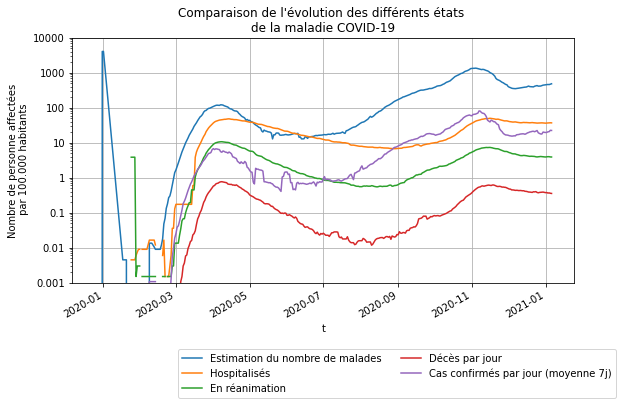

In [12]:
#collapse-hide
name_map = {
    "malades":"Estimation du nombre de malades",
    "cas_confirmes_jour_mma":"Cas confirmés par jour (moyenne 7j)",
    "hospitalises": "Hospitalisés",
    "reanimation": "En réanimation",
    "deces_jour":"Décès par jour",
}
ax = disease_states.rename(name_map, axis="columns").plot()
ax.set_yscale("log")
ax.set_ylabel("Nombre de personne affectées\n par 100.000 habitants")
ax.set_title("Comparaison de l'évolution des différents états \nde la maladie COVID-19")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick))
ax.set_ylim(0.001, 10000)
leg = ax.legend(ncol=2)
leg.set_bbox_to_anchor((0.2, -0.25))
ax.grid(which="major")
ax.figure.set_size_inches(9, 5)


In [13]:
#collapse-hide
cols = [
    "malades",
    "hospitalises",
    "reanimation",
    "deces_jour",
]
proportions = pd.DataFrame()
for col in cols:
    proportions[col] = (disease_states[col] / disease_states["malades"])
proportions_rea = pd.DataFrame()
for col in cols:
    proportions_rea[col] = (disease_states[col] / disease_states["reanimation"])


Pour mieux visualiser cette évolution, nous affichons le rapport entre les états graves et le nombre de malades supposés.

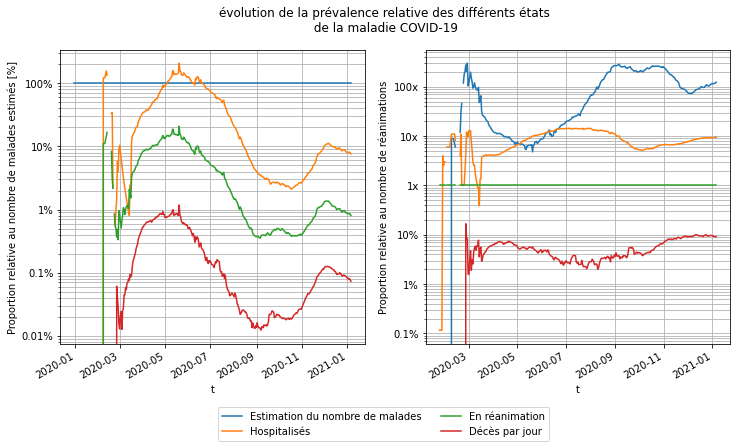

In [14]:
#collapse-hide
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

fig.suptitle("évolution de la prévalence relative des différents états\n de la maladie COVID-19")

ax = axs[0]
proportions.rename(name_map, axis="columns").plot(ax=ax)
ax.set_yscale("log")
ax.set_ylabel("Proportion relative au nombre de malades estimés [%]")
leg = ax.legend(ncol=2)
leg.set_bbox_to_anchor((0.5, -0.2))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick_percent))
ax.grid(which="both")

ax = axs[1]
proportions_rea.rename(name_map, axis="columns").plot(ax=ax)
ax.set_yscale("log")
ax.set_ylabel("Proportion relative au nombre de réanimations")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick_multi))
ax.grid(which="both")
ax.get_legend().remove()

Sur ce graphique nous voyons clairement le manque de test pendant la première vague de la pandémie où le nombre de malade supposé devient même inférieur au nombre de personnes hospitalisées. Cet effet est bien sûr un artefact du au manque de tests mais illustre bien ce déficit d’infrastructure. 
Plusieurs hypothèses existent pour expliquer ensuite la baisse très importante du nombre de cas grave par cas avérés :

* Tout d’abord faisant plus de tests, nous trouvons plus de cas, et notamment des cas moins graves sont maintenant confirmés. Ceci est en ligne avec les politiques de dépistage massif et l’accès au test qui devint facile au cours de la période Juillet-Août.
* Autre explication plausible est que des personnes plus jeunes et donc moins susceptible aux complications soit maintenant le vecteur principal de l’épidémie.
* Finalement il est possible qu’une mutation du virus l’ai rendu moins virulent, mais les informations présentées ici ne sont pas du tout suffisante pour analyser cette possibilité.

Ces données seules ne sont pas suffisantes pour dégager la responsabilité de chacun de ces effets ; une analyse de l’âge des malades et du nombre de test serait nécessaire.


Il est intéressant de remarquer que le rapport entre le nombre de malade et le nombre de personnes dans un états grave dû au COVID-19 n'a cessé de décroître jusqu'à début Septembre pour atteindre 300(malades):1(réanimation), et stagne ou remonte doucement depuis.

Cette stagnation peut-être signe que tous les cas sont détectés par le système de traçage des contacts, ou que la deuxième prend le pas sur notre capacité de tests.


## Estimation des paramètres épidémiologiques

En utilisant les ratios de la figure précedente et quelques assomptions sur la durée de la maladie il est possible d'estimer le taux de mortalité du COVID-19. Nous allons estimer successivement le risque de passer dans un état plus grave de la maladie:

* risque de décédé en réanimation;
* risque de réanimaton en hopital;
* risque d'hospitalisation lorsque malade.



### Mortalité en réanimation

Tous d'abord estimons la probabilité de décès pour une personne en réanimation. Partant de l'assomption que les décès proviennent en grande majorité des personnes en réanimation, sur le graphique précédent nous avons une notion du risque "journalier" pour une personne en réanimation qui a fluctué de 8% en Avril à 2% (en Juillet) et de retour à 5% en Octobre.

[Estimant le nombre moyen de jours en réanimation à 10](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-020-01082-z) : Nous obtiendrons donc un taux de mortalité entre 20 et 80% pour les personnes en réanimation.


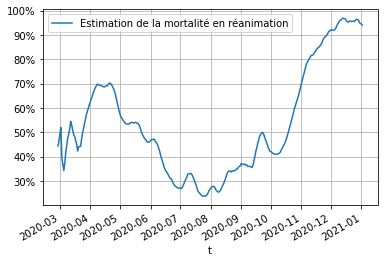

In [15]:
jours_en_rea = 10

ax = proportions_rea.rolling(jours_en_rea, center=True).sum().plot(
    y="deces_jour", label="Estimation de la mortalité en réanimation"
)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick_percent))
ax.grid(which="both")

Les nombres en Avril paraissent extrèmes car la supposition que tous les décès étaient en réanimation est certainement fausse durant le premier pic de la maladie. 

50% de mortalité en réanimation n'est pas surprenant et est en ligne avec les nombres publiés au début de l'épidémie. 

Ces données supporte l'hypothèse d'une amélioration du traitement durant l'été et lorsque les systèmes de santé étaient moins surchargés.

Conscient que l'estimation de 10 jours est grossière la même estimation est présentée pour 8 et 12 jours ci-dessous:

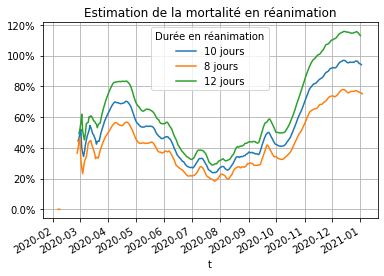

In [16]:
#collapse-hide
mortalite_rea = pd.DataFrame()
for idx in [jours_en_rea, jours_en_rea-2, jours_en_rea+2]:
    mortalite_rea[f"{idx} jours"] = proportions_rea["deces_jour"].rolling(idx, center=True).sum()

ax = mortalite_rea.plot()
ax.set_title("Estimation de la mortalité en réanimation")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick_percent))
ax.grid(which="both")
leg = ax.get_legend()
leg.set_title("Durée en réanimation")

### Risque d'entrer en réanimation

Suivant le même processus calculons la probabilité de passer en réanimation une fois hospitalisé.

Vu que hospitalisations et réanimations sont des données de même type il n'est pas necessaire de cumuler sur plusieurs jours. Nous partons donc de l'hypothèse que le ratio entre réanimation et hospitalisations indique le risque d'une personne hospitalisé.


Text(0, 0.5, 'Risque de réanimation pour personne hospitalisée')

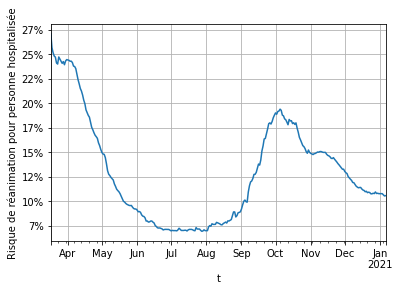

In [17]:
risque_rea = (1.0/proportions_rea["hospitalises"]).loc['2020-03-17':]

ax = risque_rea.plot()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick_percent))
ax.grid(which="major")
ax.set_ylabel("Risque de réanimation pour personne hospitalisée")

Cette variation du taux d'hospitalisation/réanimation n'est pas explicable avec les données analysées ici. Dans mon post précédent on observe que le nombre d'hospitalisés n'est jamais redescendu aussi bas que le nombre de cas ou de réanimation. Cela suggère un effet de la maladie qui n'est pas capturé par nos suppositions.

En multipliant ce risque hospitalisation/réanimation au taux de mortalité en réanimation nous pouvons calculer un taux de mortalité en hôpital: celui ci était de 15% pendant le premier pic et oscille autour de 7% en ce moment.

In [18]:
mortalite_hos = pd.DataFrame()
for col in mortalite_rea:
    mortalite_hos[col] = risque_rea * mortalite_rea[col]


Text(0, 0.5, 'Mortalité pour personne hospitalisée')

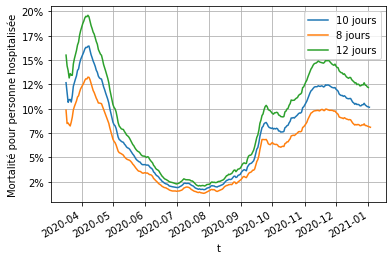

In [19]:
ax = mortalite_hos.plot()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick_percent))
ax.grid(which="major")
ax.set_ylabel("Mortalité pour personne hospitalisée")

### Risques pour une personne malade

Suivant le même processus nous pouvons estimé le taux de mortalité 

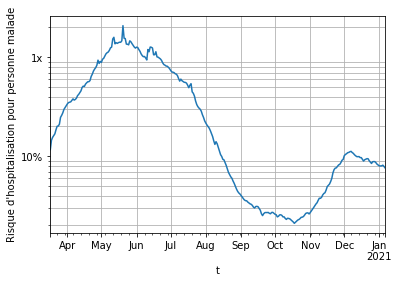

In [20]:
risque_hosp = (proportions["hospitalises"]).loc['2020-03-17':]

ax = risque_hosp.plot()
ax.grid(which="major")
ax.set_ylabel("Risque d'hospitalisation pour personne malade")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick_multi))
ax.yaxis.grid(which="both")

In [21]:
mortalite_malade = pd.DataFrame()
for col in mortalite_hos:
    mortalite_malade[col] = risque_hosp * mortalite_hos[col]

Text(0, 0.5, 'Mortalité pour personne malade')

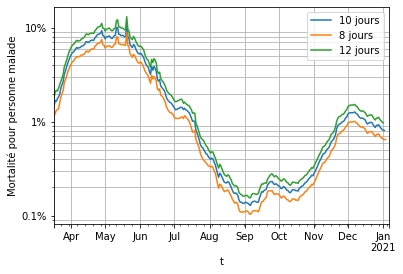

In [22]:
ax = mortalite_malade.loc['2020-03-17':].plot()
ax.set_yscale("log")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick_percent))
ax.grid(which="major")
ax.yaxis.grid(which="both")
ax.set_ylabel("Mortalité pour personne malade")

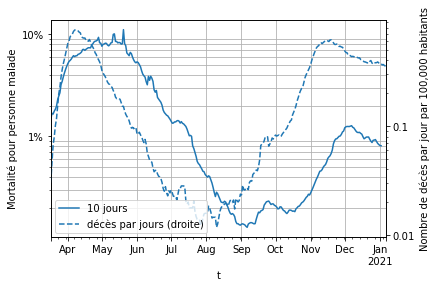

In [23]:
ax = mortalite_malade["10 jours"].loc['2020-03-17':].plot()
ax.set_yscale("log")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick_percent))
ax.grid(which="major")
ax.yaxis.grid(which="both")
ax.set_ylabel("Mortalité pour personne malade")
ax2 = ax.twinx()
disease_states["deces_jour"].loc['2020-03-17':].plot(ax=ax2, ls="--", label="décès par jours (droite)")
ax2.set_yscale("log")
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(format_tick))
ax2.set_ylabel("Nombre de décès par jour par 100,000 habitants")
leg = ax.figure.legend(loc="lower left")
leg.set_bbox_to_anchor((0.115, 0.17))

## Analyse des durées dans les états différents

Ces analyses sont très grossière et sont des ébauches à compléter.

### Combien de temps passent les malades en réanimation?

Temps moyen en réanimation: 13.33 jours


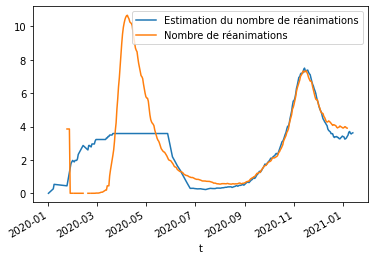

In [24]:
proportions_rea_longues = 1/3
duree_rea_longue = 28
duree_rea_courte = 6
ax = (
    (
        viz.state_tracking(fra["nouvelles_reanimations"] * proportions_rea_longues, 0, duree_rea_longue) +
        viz.state_tracking(fra["nouvelles_reanimations"] * (1-proportions_rea_longues), 0, duree_rea_courte)
    )
    / pop_france_par_100000
).plot(label="Estimation du nombre de réanimations")
disease_states["reanimation"].plot(ax=ax, label="Nombre de réanimations")
ax.legend()
moyenne_rea = (
    proportions_rea_longues * duree_rea_longue + (1-proportions_rea_longues) * duree_rea_courte 
)
print(f"Temps moyen en réanimation: {moyenne_rea:.2f} jours")

Plus haut nous faisons l'assomption que tous les décès sont tirés des personnes en réanimation. Celà est faux: le nombre d'entrée en réanimation est bien moindre que le nombre de décès sur la durée d'une période en réanimation.

In [25]:
fra[["nouvelles_reanimations", "deces_jour"]].tail(20)

,nouvelles_reanimations,deces_jour
t,,
2020-12-25,112.0,159.0
2020-12-26,101.0,146.0
2020-12-27,107.0,173.0
2020-12-28,229.0,363.0
2020-12-29,251.0,384.0
2020-12-30,209.0,303.0
2020-12-31,176.0,251.0
2021-01-01,99.0,133.0
2021-01-02,101.0,156.0


### Combien de temps passent les malades à l'hopital?

Temps moyen à l'hôpital: 14.75 jours


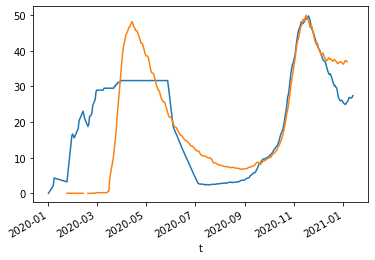

In [26]:
proportions_hosp_longues = 1/4
duree_hosp_longue = 38
duree_hosp_courte = 7
ax = (
    (
        viz.state_tracking(fra["nouvelles_hospitalisations"] * proportions_hosp_longues, 0, duree_hosp_longue) +
        viz.state_tracking(fra["nouvelles_hospitalisations"] * (1-proportions_hosp_longues), 0, duree_hosp_courte)
    ) 
    / pop_france_par_100000
).plot()
disease_states["hospitalises"].plot(ax=ax)
moyenne_hospitalisation = (
    proportions_hosp_longues * duree_hosp_longue + (1-proportions_hosp_longues) * duree_hosp_courte 
)
print(f"Temps moyen à l'hôpital: {moyenne_hospitalisation:.2f} jours")

## Estimation de R

Nous pouvons tenter d'estimer R depuis notre estimation du nombre de malade et l

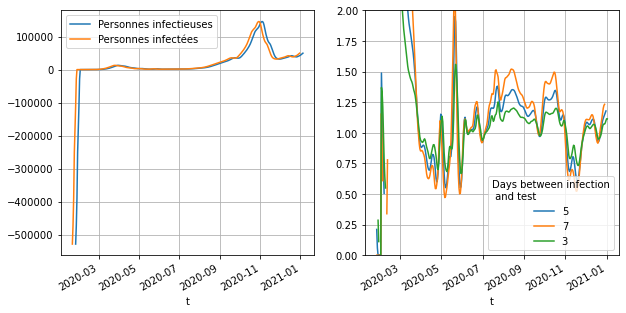

In [27]:
infectious_period_around_test = [-2, 1]
infect_to_test_base = -5
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
windowing = dict(window=14, win_type="triang", center=True)

for offset in [0, -2, 2]:
    infect_to_test = infect_to_test_base + offset
    infectieux = viz.state_tracking(
        fra["cas_confirmes_jour"], 
        *infectious_period_around_test
    ).rolling(**windowing).mean()
    infectes = viz.state_tracking(
        fra["cas_confirmes_jour"], 
        *[i+infect_to_test for i in infectious_period_around_test]
    ).rolling(**windowing).mean()
    if offset == 0:
        infectieux.plot(ax = axs[0], label="Personnes infectieuses")
        infectes.plot(ax = axs[0], label="Personnes infectées")
    R = infectes / infectieux
    R.plot(ax=axs[1], label=f"{-infect_to_test}")
axs[0].legend()
axs[1].legend().set_title("Days between infection\n and test")
axs[1].set_ylim((0,2))
for ax in axs:
    ax.grid("on")

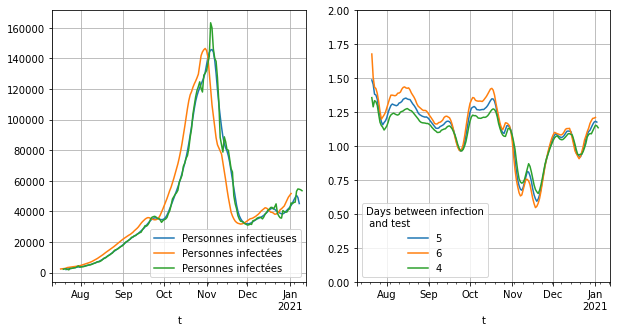

In [31]:
viz.plot_R(
    fra.loc["2020-07-15" < fra.index, :],
    infectious_period_around_test = [-1, 2],
    infect_to_test_base = -5,
)